In [73]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest
import geopandas as gpd
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

In [74]:
state_df = pd.read_csv('../input/covid19-in-india/StatewiseTestingDetails.csv')
country_df = pd.read_csv('../input/covid19-in-india/covid_19_india.csv')

In [75]:
state_df.head()

,Date,State,TotalSamples,Negative,Positive
0,2020-04-17,Andaman and Nicobar Islands,1403.0,1210,12.0
1,2020-04-24,Andaman and Nicobar Islands,2679.0,NaN,27.0
2,2020-04-27,Andaman and Nicobar Islands,2848.0,NaN,33.0
3,2020-05-01,Andaman and Nicobar Islands,3754.0,NaN,33.0
4,2020-05-16,Andaman and Nicobar Islands,6677.0,NaN,33.0


In [76]:
state_df.head()

,Date,State,TotalSamples,Negative,Positive
0,2020-04-17,Andaman and Nicobar Islands,1403.0,1210,12.0
1,2020-04-24,Andaman and Nicobar Islands,2679.0,NaN,27.0
2,2020-04-27,Andaman and Nicobar Islands,2848.0,NaN,33.0
3,2020-05-01,Andaman and Nicobar Islands,3754.0,NaN,33.0
4,2020-05-16,Andaman and Nicobar Islands,6677.0,NaN,33.0


In [77]:
state_df[state_df['State']=='Tamil Nadu'].head()

,Date,State,TotalSamples,Negative,Positive
12492,2020-04-03,Tamil Nadu,3684.0,2789,411.0
12493,2020-04-08,Tamil Nadu,5305.0,4414,690.0
12494,2020-04-09,Tamil Nadu,7267.0,5824,834.0
12495,2020-04-10,Tamil Nadu,8410.0,6838,911.0
12496,2020-04-11,Tamil Nadu,9842.0,7779,969.0


In [78]:
country_df[((country_df['Date']=='2020-03-30')&(country_df['State/UnionTerritory']=='Tamil Nadu'))]

,Sno,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
495,496,2020-03-30,9:30 PM,Tamil Nadu,-,-,4,1,67


In [79]:
#Copying the contry_df data to df for easy reference
df=country_df.copy()

In [80]:
#Keeping it simple, we will drop the rows with state name ending with "***" as it is seems to be rows with incomplete values.
def drop_star(df):
    for i in df['State/UnionTerritory'].iteritems():
        if i[1][-3:] == "***":
            df.drop(i[0],inplace=True)
        
drop_star(df)
df['State/UnionTerritory'].unique()

array(['Kerala', 'Telengana', 'Delhi', 'Rajasthan', 'Uttar Pradesh',
       'Haryana', 'Ladakh', 'Tamil Nadu', 'Karnataka', 'Maharashtra',
       'Punjab', 'Jammu and Kashmir', 'Andhra Pradesh', 'Uttarakhand',
       'Odisha', 'Puducherry', 'West Bengal', 'Chhattisgarh',
       'Chandigarh', 'Gujarat', 'Himachal Pradesh', 'Madhya Pradesh',
       'Bihar', 'Manipur', 'Mizoram', 'Andaman and Nicobar Islands',
       'Goa', 'Unassigned', 'Assam', 'Jharkhand', 'Arunachal Pradesh',
       'Tripura', 'Nagaland', 'Meghalaya',
       'Dadra and Nagar Haveli and Daman and Diu',
       'Cases being reassigned to states', 'Sikkim', 'Daman & Diu',
       'Lakshadweep', 'Telangana', 'Dadra and Nagar Haveli',
       'Himanchal Pradesh', 'Karanataka'], dtype=object)

In [81]:
#lets convert the Date feature to Date&time datatype
df['Date']=pd.to_datetime(df['Date'],format='%Y-%m-%d')

#Time is not required as it doesnt make much difference
df.drop(['Time'],axis=1, inplace=True)

#Renaming State/UnionTerritory to States for easy reference
df.rename(columns={'State/UnionTerritory':'States'}, inplace=True)

In [82]:
df['Active_cases']=df['Confirmed']-(df['Cured']+df['Deaths'])
df['Discharge_Rate'] = np.round((df['Cured']/df['Confirmed'])*100, decimals = 4)      # create instances for 'death_rate and discharge_rate'
df['Death_Rate'] = np.round((df['Deaths']/df['Confirmed'])*100, decimals = 4)
df.head()

,Sno,Date,States,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed,Active_cases,Discharge_Rate,Death_Rate
0,1,2020-01-30,Kerala,1,0,0,0,1,1,0.0,0.0
1,2,2020-01-31,Kerala,1,0,0,0,1,1,0.0,0.0
2,3,2020-02-01,Kerala,2,0,0,0,2,2,0.0,0.0
3,4,2020-02-02,Kerala,3,0,0,0,3,3,0.0,0.0
4,5,2020-02-03,Kerala,3,0,0,0,3,3,0.0,0.0


In [83]:
df[df['States']=='Tamil Nadu'].tail()

,Sno,Date,States,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed,Active_cases,Discharge_Rate,Death_Rate
17636,17637,2021-07-29,Tamil Nadu,-,-,2498289,33995,2553805,21521,97.8261,1.3312
17672,17673,2021-07-30,Tamil Nadu,-,-,2500434,34023,2555664,21207,97.8389,1.3313
17708,17709,2021-07-31,Tamil Nadu,-,-,2502627,34050,2557611,20934,97.8502,1.3313
17744,17745,2021-08-01,Tamil Nadu,-,-,2504805,34076,2559597,20716,97.8594,1.3313
17780,17781,2021-08-02,Tamil Nadu,-,-,2506961,34102,2561587,20524,97.8675,1.3313


In [84]:
df[df['States']=='Maharashtra'].tail()

,Sno,Date,States,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed,Active_cases,Discharge_Rate,Death_Rate
17626,17627,2021-07-29,Maharashtra,-,-,6064856,132145,6282914,85913,96.5293,2.1032
17662,17663,2021-07-30,Maharashtra,-,-,6075888,132335,6290156,81933,96.5936,2.1038
17698,17699,2021-07-31,Maharashtra,-,-,6083319,132566,6296756,80871,96.6104,2.1053
17734,17735,2021-08-01,Maharashtra,-,-,6090786,132791,6303715,80138,96.6222,2.1066
17770,17771,2021-08-02,Maharashtra,-,-,6094896,132948,6310194,82350,96.5881,2.1069


In [85]:
df[df['States']=='West Bengal'].tail()

,Sno,Date,States,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed,Active_cases,Discharge_Rate,Death_Rate
17641,17642,2021-07-29,West Bengal,-,-,1496294,18109,1525773,11370,98.0679,1.1869
17677,17678,2021-07-30,West Bengal,-,-,1497116,18123,1526539,11300,98.0726,1.1872
17713,17714,2021-07-31,West Bengal,-,-,1497951,18128,1527250,11171,98.0816,1.1870
17749,17750,2021-08-01,West Bengal,-,-,1498770,18136,1528019,11113,98.0858,1.1869
17785,17786,2021-08-02,West Bengal,-,-,1499597,18149,1528720,10974,98.0949,1.1872


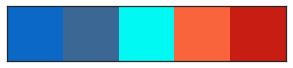

In [86]:
import matplotlib.pyplot as plt
import matplotlib.dates as mtd
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
colors=['#0C68C7','#3A6794','#00FAF3','#FA643C','#C71D12']
sns.set(palette=colors, style='white')

sns.palplot(colors)

In [87]:
#Current date from the record
current = df[df.Date == '2021-07-06']

In [88]:
#Sorting data in descending ordrer (Confirmed)
max_confirmed_cases = current.sort_values(by='Confirmed', ascending = False)
max_confirmed_cases.head()

,Sno,Date,States,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed,Active_cases,Discharge_Rate,Death_Rate
16798,16799,2021-07-06,Maharashtra,-,-,5861720,123136,6104917,120061,96.0164,2.0170
16794,16795,2021-07-06,Kerala,-,-,2866806,13818,2981721,101097,96.1460,0.4634
16793,16794,2021-07-06,Karnataka,-,-,2779038,35434,2856491,42019,97.2885,1.2405
16808,16809,2021-07-06,Tamil Nadu,-,-,2432017,33059,2500002,34926,97.2806,1.3224
16779,16780,2021-07-06,Andhra Pradesh,-,-,1858189,12870,1905023,33964,97.5416,0.6756


In [89]:
#Selecting top 10 States/U.T
top_cases = max_confirmed_cases[:10]
top_cases.head()

,Sno,Date,States,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed,Active_cases,Discharge_Rate,Death_Rate
16798,16799,2021-07-06,Maharashtra,-,-,5861720,123136,6104917,120061,96.0164,2.0170
16794,16795,2021-07-06,Kerala,-,-,2866806,13818,2981721,101097,96.1460,0.4634
16793,16794,2021-07-06,Karnataka,-,-,2779038,35434,2856491,42019,97.2885,1.2405
16808,16809,2021-07-06,Tamil Nadu,-,-,2432017,33059,2500002,34926,97.2806,1.3224
16779,16780,2021-07-06,Andhra Pradesh,-,-,1858189,12870,1905023,33964,97.5416,0.6756


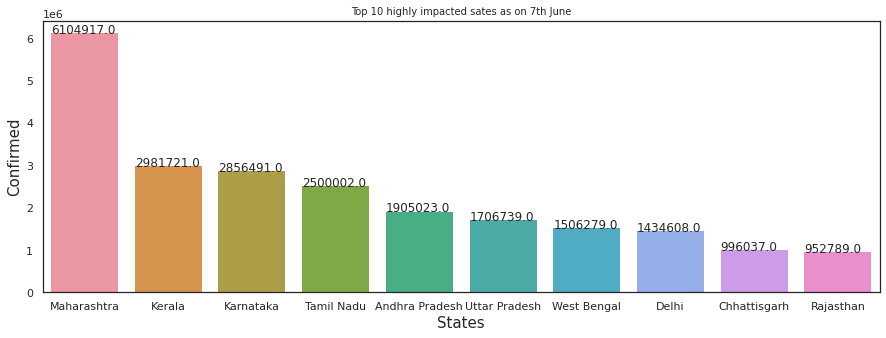

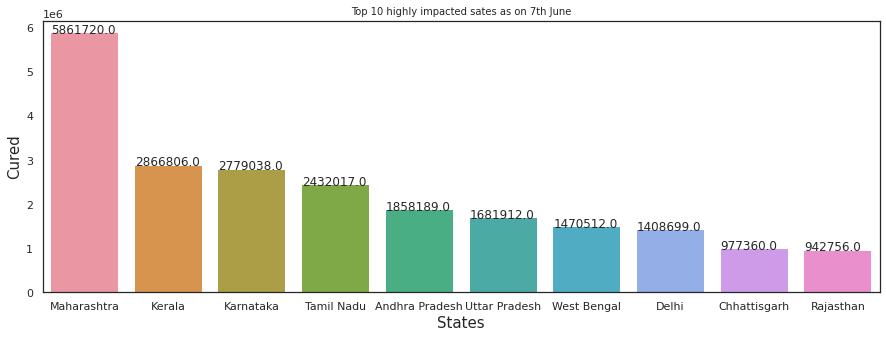

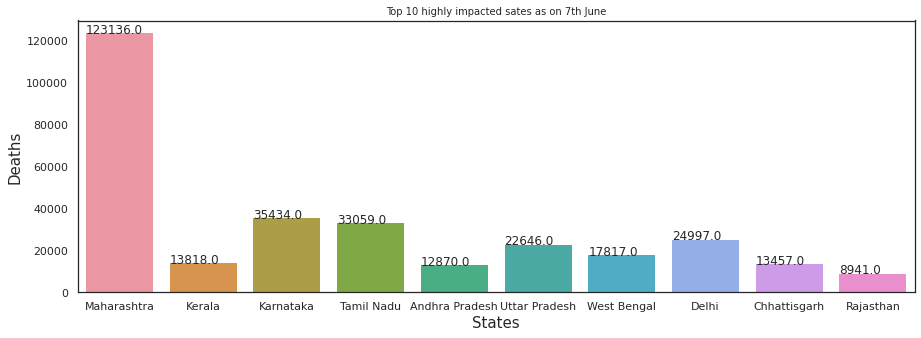

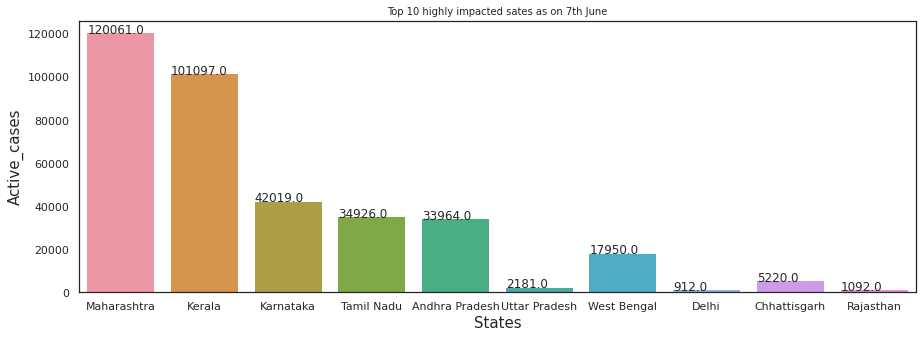

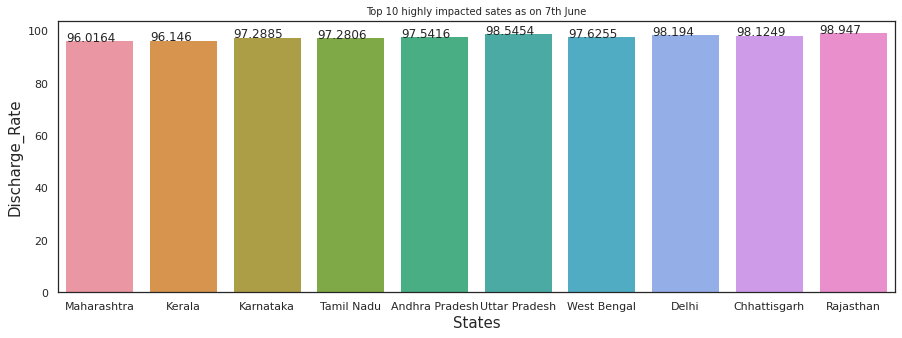

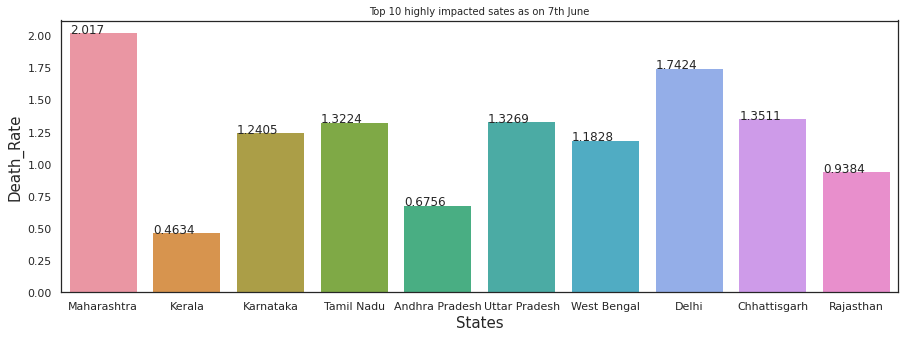

In [90]:
for feature in top_cases[['Confirmed','Cured','Deaths','Active_cases','Discharge_Rate','Death_Rate']]:
    fig=plt.figure(figsize=(15,5))
    plt.title("Top 10 highly impacted sates as on 7th June", size=10)
    ax=sns.barplot(data=top_cases,y=top_cases[feature],x='States', linewidth=0, edgecolor='black')
    plt.xlabel('States', size = 15)
    plt.ylabel(feature, size = 15)
    for i in ax.patches:
        ax.text(x=i.get_x(),y=i.get_height(),s=i.get_height())
plt.show()

In [91]:
states=['Kerala', 'Tamil Nadu', 'Maharashtra', 'Tamil Nadu', 'Andhra Pradesh', 'Uttar Pradesh']
mh=df[df['States']=='Maharashtra']
kl=df[df['States']=='Kerala']
ka=df[df['States']=='Karnataka']
tn=df[df['States']=='Tamil Nadu']
ap=df[df['States']=='Andhra Pradesh']
up=df[df['States']=='Uttar Pradesh']

In [ ]:
fig, ax=plt.subplots(nrows=3, ncols=3, figsize=(23,10), squeeze=False, sharex=True, sharey=False, constrained_layout=True )
plt.suptitle("Comparison of Active, Cured & Deaths for top States", size = 25)
sns.lineplot(data=tn, x='Date',y='Active_cases', ax=ax[0,0], color=colors[1])
ax[0,0].set_title("Maharashtra", size=20)
sns.lineplot(data=tn, x='Date',y='Cured', ax=ax[1,0], color=colors[1])
sns.lineplot(data=tn, x='Date',y='Deaths', ax=ax[2,0], color=colors[1])

sns.lineplot(data=kl, x='Date',y='Active_cases', ax=ax[0,1], color=colors[2])
ax[0,1].set_title("Kerala", size=20)
sns.lineplot(data=kl, x='Date',y='Cured', ax=ax[1,1], color=colors[2])
sns.lineplot(data=kl, x='Date',y='Deaths', ax=ax[2,1], color=colors[2])

sns.lineplot(data=mh, x='Date',y='Active_cases', ax=ax[0,2], color=colors[3])
ax[0,2].set_title("Karnataka", size=20)
sns.lineplot(data=mh, x='Date',y='Cured', ax=ax[1,2], color=colors[3])
sns.lineplot(data=mh, x='Date',y='Deaths', ax=ax[2,2], color=colors[3])
plt.show()

In [ ]:
fig, ax=plt.subplots(nrows=3, ncols=3, figsize=(23,10), squeeze=False, sharex=True, sharey=False, constrained_layout=True )
sns.lineplot(data=tn, x='Date',y='Active_cases', ax=ax[0,0], color=colors[1])
ax[0,0].set_title("Tamil Nadu", size=20)
sns.lineplot(data=tn, x='Date',y='Cured', ax=ax[1,0], color=colors[1])
sns.lineplot(data=tn, x='Date',y='Deaths', ax=ax[2,0], color=colors[1])

sns.lineplot(data=kl, x='Date',y='Active_cases', ax=ax[0,1], color=colors[2])
ax[0,1].set_title("Andhra Pradesh", size=20)
sns.lineplot(data=kl, x='Date',y='Cured', ax=ax[1,1], color=colors[2])
sns.lineplot(data=kl, x='Date',y='Deaths', ax=ax[2,1], color=colors[2])

sns.lineplot(data=mh, x='Date',y='Active_cases', ax=ax[0,2], color=colors[3])
ax[0,2].set_title("Uttar Pradesh", size=20)
sns.lineplot(data=mh, x='Date',y='Cured', ax=ax[1,2], color=colors[3])
sns.lineplot(data=mh, x='Date',y='Deaths', ax=ax[2,2], color=colors[3])
plt.show()

In [ ]:
df['Date']= pd.to_datetime(df['Date'])          # Date is converted to DateTime format.
data_20 = df[df['Date'].dt.year==2020]               # Considering data of only the year 2020.   
data_21 = df[df['Date'].dt.year==2021]               # Considering data of only the year 2021.  

data_20['Month']=data_20['Date'].dt.month                    # Month is accessed from the DateTime object.
data_21['Month']=data_21['Date'].dt.month    

#Year 2020
data_confirm_20= data_20['Confirmed'].groupby(data_20['Month']).sum()
data_dis_20= data_20['Cured'].groupby(data_20['Month']).sum()      # creating instances for 'confirmed','deaths','discharged' by month column
data_death_20= data_20['Deaths'].groupby(data_20['Month']).sum()

#Year 2021
data_confirm_21= data_21['Confirmed'].groupby(data_21['Month']).sum()
data_dis_21= data_21['Cured'].groupby(data_21['Month']).sum()      # creating instances for 'confirmed','deaths','discharged' by month column
data_death_21= data_21['Deaths'].groupby(data_21['Month']).sum()

cols_20=[data_confirm_20,data_dis_20,data_death_20]
data_20=pd.concat(cols_20,axis=1)  

cols_21=[data_confirm_21,data_dis_21,data_death_21]
data_21=pd.concat(cols_21,axis=1) 

#Year 2020
data_20['discharge_rate_20'] = np.round((data_20['Cured']/data_20['Confirmed'])*100, decimals=4)      # create instances for 'death_rate and discharge_rate'
data_20['death_rate_20'] = np.round((data_20['Deaths']/data_20['Confirmed'])*100, decimals=4)

#Year 2020
data_21['discharge_rate_21'] = np.round((data_21['Cured']/data_21['Confirmed'])*100, decimals=4)      # create instances for 'death_rate and discharge_rate'
data_21['death_rate_21'] = np.round((data_21['Deaths']/data_21['Confirmed'])*100, decimals=4)

In [ ]:
#Year 2020
data_20.reset_index(inplace=True)
data_20.head()

In [ ]:
#Year 2021
data_21.reset_index(inplace=True)
data_21.head()

In [ ]:
plt.figure(figsize=(10,5))
sns.lineplot(x="Month",y="discharge_rate_20",data=data_20,color="g",lw=3,marker='o',markersize=10)
plt.title('DISCHARGE RATE PER MONTH IN 2020')
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
sns.lineplot(x="Month",y="discharge_rate_21",data=data_21,color="g",lw=3,marker='o',markersize=10)
plt.title('DISCHARGE RATE PER MONTH IN 2021')
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
sns.lineplot(x="Month",y="death_rate_20",data=data_20,color="r",lw=3,marker='o',markersize=10)
plt.title('DEATH RATE PER MONTH IN 2020')
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
sns.lineplot(x="Month",y="death_rate_21",data=data_21,color="r",lw=3,marker='o',markersize=10)
plt.title('DEATH RATE PER MONTH IN 2021')
plt.show()

In [ ]:
tn=df[df['States']=='Tamil Nadu']['Cured']
mh=df[df['States']=='Maharashtra']['Cured']
kl=df[df['States']=='Kerala']['Cured']

In [ ]:
df.head()

In [ ]:
print('Total number of Active Covid-19 cases across India : {}'.format(max_confirmed_cases['Active_cases'].sum()))
top_cases = max_confirmed_cases.groupby('States')['Active_cases'].max().sort_values(ascending=False).to_frame()
top_cases.style.background_gradient(cmap='flare')

In [ ]:
from fbprophet import Prophet
confirmed = df.groupby('Date').sum()['Confirmed'].reset_index()
recovered = df.groupby('Date').sum()['Cured'].reset_index()
deaths = df.groupby('Date').sum()['Deaths'].reset_index()
confirmed.head()

In [ ]:
confirmed.columns = ['ds', 'y']
confirmed['ds'] = pd.to_datetime(confirmed['ds'])

In [ ]:
m = Prophet(interval_width=0.95)
m.fit(confirmed)
future = m.make_future_dataframe(periods=7)       #Making future prediction for next 7 days
future.tail(10)

In [ ]:
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

In [ ]:
confirmed_forecast_plot = m.plot(forecast)

In [ ]:
confirmed_forecast_plot = m.plot_components(forecast)

In [ ]:
print('Average recovery rate Covid-19 cases across India : {}'.format(max_confirmed_cases['Discharge_Rate'].mean()))
top_cases = max_confirmed_cases.groupby('States')['Discharge_Rate'].max().sort_values(ascending=False).to_frame()
top_cases.style.background_gradient(cmap='flare')

In [ ]:
discharge_rate = df[['Date','Discharge_Rate']]
discharge_rate.head()

In [ ]:
discharge_rate.columns = ['ds', 'y']
discharge_rate['ds'] = pd.to_datetime(discharge_rate['ds'])

In [ ]:
m = Prophet(interval_width=0.50)
m.fit(discharge_rate)
future = m.make_future_dataframe(periods=7)      

In [ ]:
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

In [ ]:
confirmed_forecast_plot = m.plot(forecast)

In [ ]:
confirmed_forecast_plot = m.plot_components(forecast)

In [ ]:
print('Average recovery rate Covid-19 cases across India : {}'.format(max_confirmed_cases['Discharge_Rate'].mean()))
top_cases = max_confirmed_cases.groupby('States')['Death_Rate'].max().sort_values(ascending=False).to_frame()
top_cases.style.background_gradient(cmap='flare')

In [ ]:
discharge_rate = df[['Date','Death_Rate']]
discharge_rate.head()

In [ ]:
discharge_rate.columns = ['ds', 'y']
discharge_rate['ds'] = pd.to_datetime(discharge_rate['ds'])

In [ ]:
m = Prophet(interval_width=0.50)
m.fit(discharge_rate)
future = m.make_future_dataframe(periods=7)       #Making future prediction for next 7 days
future.tail(10)

In [ ]:
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

In [ ]:
df.head()

In [ ]:

state_cases = max_confirmed_cases.drop(['Sno','Date','ConfirmedIndianNational',
                                       'ConfirmedForeignNational'],axis=1)

state_wise_cases = state_cases.sort_values('Confirmed', ascending= False).fillna(0).style.background_gradient(cmap='Blues',subset=["Confirmed"])\
                        .background_gradient(cmap='Reds',subset=["Deaths"])\
                        .background_gradient(cmap='Greens',subset=["Cured"])\
                        .background_gradient(cmap='Oranges',subset=["Active_cases"])\
                        .background_gradient(cmap='RdYlBu',subset=["Death_Rate"])\
                        .background_gradient(cmap='Accent',subset=["Discharge_Rate"])

state_wise_cases

In [ ]:
#Loading the vaccination data
vaccine_df = pd.read_csv('../input/covid19-in-india/covid_vaccine_statewise.csv')

In [ ]:
vacc_df=vaccine_df.copy()
vaccine_df = vaccine_df[['Updated On','State','Total Doses Administered','Total Sessions Conducted','First Dose Administered','Second Dose Administered','Male(Individuals Vaccinated)','Female(Individuals Vaccinated)','Transgender(Individuals Vaccinated)','Total Covaxin Administered','Total CoviShield Administered','Total Sputnik V Administered','18-45 years (Age)','45-60 years (Age)','60+ years (Age)','Total Individuals Vaccinated']]
vaccine_df.columns = ['Date','States','Total_Doses_Administered','Total_Sessions_Conducted','First_Dose_Administered','Second_Dose_Administered','Male_Vaccinated','Female_Vaccinated','Transgender_Vaccinated','Total_Covaxin_Administered','Total_CoviShield_Administered','Total_SputnikV_Administered','18-45_Years','45-60_Years','60+_Years','Total_Individuals_Vaccinated']
vaccine_df.head()

In [ ]:
#Checking the null values
vaccine_df.isnull().sum()

In [ ]:
vaccine_df = vaccine_df[vaccine_df['Total_Individuals_Vaccinated'].notna()]

In [ ]:
vaccine_df['Date'] = pd.to_datetime(vaccine_df['Date'], format = '%d/%m/%Y')
latest_date = max(vaccine_df['Date'])
print("Current Date : ", latest_date)

In [ ]:
vaccine_df[vaccine_df['States'] == "Dadra and Nagar Haveli and Daman and Diu"]

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1, dpi=100, figsize=(6,4))

sns.lineplot(data=vaccine_df[vaccine_df['States']=='India'], x='Date', y='Total_Individuals_Vaccinated', ax=ax)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(DateFormatter('%b%y'))
ax.set_ylabel('Total Indians Vaccinated so far in millions', fontsize=10)
ax.set_yticklabels([0,0,20,40,60,80,100,120])

Xstart, Xend = ax.get_xlim()
plt.title('India\'s Vaccination Performance')
plt.show()